<a href="https://colab.research.google.com/github/godinezseba/Tarea-2-RedesNeuronales/blob/master/notebooks/Parte%202/pruebas/GRU%2Bnode2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/yekenot/pooled-gru-fasttext

In [ ]:
!git clone https://github.com/godinezseba/Tarea-2-RedesNeuronales

Cloning into 'Tarea-2-RedesNeuronales'...
remote: Enumerating objects: 2152, done.
remote: Counting objects: 100% (2152/2152), done.
remote: Compressing objects: 100% (2152/2152), done.
remote: Total 35840 (delta 1), reused 2148 (delta 0), pack-reused 33688
Receiving objects: 100% (35840/35840), 797.68 MiB | 24.74 MiB/s, done.
Resolving deltas: 100% (325/325), done.
Checking out files: 100% (36724/36724), done.


In [ ]:
!pip install tweet-preprocessor
%pip install scanf==1.5.2
%pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 8.4MB/s 
     |████████████████████████████████| 235kB 11.0MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

Using TensorFlow backend.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.metrics import  classification_report
import re

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Cargar datos

In [ ]:
train = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

In [ ]:
labels = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_labels.csv' )

In [ ]:
test = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/test_source_tweets.txt', sep='\t', names = ['ID','Tweet'] )

# Grafos

In [ ]:
import os.path
from scanf import scanf
from gensim.models import Word2Vec
import networkx as nx
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

import matplotlib.pyplot as plt
%matplotlib inline

## Creación de grafos

In [ ]:
def createGraph(DIR, fileGraph, labels):
  if(not os.path.exists(fileGraph)): # para ejecutar existiendo el archivo basta con quital el 'not'
    format = "['%s', '%s', '%f']->['%s', '%s', '%f']"
    # edges
    source = list()
    target = list()
    # nodes
    index = list()
    time = list()

    bigGraph = nx.Graph()

    list_len_edges = list()

    for file in labels:
      fileName = f'{DIR}/{file}.txt'
      count_edges = 0
      with open(fileName, 'r') as f:
        for line in f:
          parentId, parentTweet, parentTime, childId, childTweet, childTime = scanf(format, line.strip())
          if(parentId != 'ROOT'):
            # add edge to the big Graph
            bigGraph.add_edge(parentTweet, childTweet)
            count_edges += 1
            bigGraph.add_node(parentTweet, time=[parentTime])
            bigGraph.add_node(childTweet, time=[childTime])
      list_len_edges.append(count_edges)

    nx.write_gpickle(bigGraph, fileGraph)
  else:
    list_len_edges = list()
    bigGraph = nx.read_gpickle(fileGraph)
  return bigGraph, list_len_edges

In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/train'
fileGraph = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, labels['id'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 67723
Number of edges: 71020
Average degree:   2.0974
StellarGraph: Undirected multigraph
 Nodes: 67723, Edges: 71020

 Node types:
  default: [67723]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [71020]
        Weights: all 1 (default)
        Features: none


## Embedding

In [ ]:
vectorDimension = 256
def graphEmbedding(graph, file, labels):
  if( os.path.exists(file)): # para ejecutar existiendo el archivo basta con quital el 'not'
    rw = BiasedRandomWalk(graph)

    root_nodes = [str(n) for n in labels]

    walks = rw.run(
        nodes=root_nodes,  # root nodes
        length=200,  # maximum length of a random walk
        n=100,  # number of random walks per root node
        p=0.5,
        q=2.0
    )
    print("Number of random walks: {}".format(len(walks)))

    str_walks = [[str(n) for n in walk] for walk in walks]
    embedding = Word2Vec(str_walks, 
                        size=vectorDimension, 
                        window=5, 
                        min_count=0, 
                        sg=1, 
                        workers=4, 
                        iter=1)
    embedding.save(file)
  else:
    embedding = Word2Vec.load(file)
  return embedding

In [ ]:
file_train = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/node.word2vec'

embedding = graphEmbedding(graph, file_train, labels['id'])

embeddings = np.array([embedding.wv[str(x)] for x in labels['id']])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#Limpiar datos

In [ ]:
#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [ ]:
# clean training data
train_tweet = clean_tweets(train["Tweet"])
train_tweet = pd.DataFrame(train_tweet)
# append cleaned tweets to the training data
train["clean_tweet"] = train_tweet

In [ ]:
# compare the cleaned and uncleaned tweets
train.head(10)

,ID,Tweet,clean_tweet
0,692735698349199360,north korea 'planning some kind of rocket laun...,north korea planning some kind of rocket launc...
1,525008463819464704,"meet kevin vickers, the hero who shot down the...",meet kevin vickers the hero who shot down the ...
2,505611045897924608,"15 year old who ""swatted"" gamer convicted of d...",year old who swatted gamer convicted of domest...
3,693466724822323200,audio recordings reveal cpr started 11 minutes...,audio recordings reveal cpr started minutes af...
4,510922415468449792,awful mt @scclemons:uk aid worker david haines...,awful mt uk aid worker david haines beheaded b...
5,549975297160802304,dammit - a transgender 17-year-old left a suic...,dammit a transgender year old left a suicid...
6,500378522788315137,#ferguson police: officer involved in fatal sh...,police officer involved in fatal shooting of m...
7,528607634099015680,#animaloftheday: the first afghan fanged deer ...,the first afghan fanged deer was seen in more...
8,489854703321509888,"'nine britons, 23 us citizens and 80 children'...",nine britons us citizens and children feared d...
9,521444489697583104,photos proved that terrorists used chemical we...,photos proved that terrorists used chemical we...


In [ ]:

# clean the test data and append the cleaned tweets to the test data
test_tweet = clean_tweets(test["Tweet"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["clean_tweet"] = test_tweet

# compare the cleaned and uncleaned tweets
test.tail()

,ID,Tweet,clean_tweet
208,642432477185867776,the stickers on fruit are edible.,the stickers on fruit are edible
209,693236688538243074,"is the truth out there? in nod to @thexfiles, ...",is the truth out there in nod to releases hun...
210,504131150429061121,breaking: fbi uncovers new audio from neighbor...,breaking fbi uncovers new audio from neighbor ...
211,692004901455556608,.@potus just announced new reforms to address ...,just announced new reforms to address the ove...
212,692157602554343424,waiting for the new episode of #teenwolf like....,waiting for the new episode of like url


#Embedding

In [ ]:
embed_dim = 32

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

import string
from nltk.tokenize import word_tokenize



review_lines = list()
lines = train['Tweet'].values.tolist()

for line in lines:
  tokens = word_tokenize(line)
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens] 
  words = [word for word in stripped if word.isalpha()]
  review_lines.append(words)
  
len(review_lines)


1926

In [ ]:
import gensim

model = gensim.models.Word2Vec(sentences = review_lines, size = embed_dim, 
                               window = 5, workers = 4, min_count = 0)
words = list(model.wv.vocab)
print('Tamaño vocabulario', len(words))

Tamaño vocabulario 5456


In [ ]:
word_ids = model.wv.index2word  # list of node IDs
word_embeddings = (model.wv.vectors)
#print(word_embeddings[0])
print(len(word_ids))

5456


In [ ]:
embedding_matrix = np.zeros((len(word_ids),embed_dim))


for i in range(embedding_matrix.shape[0]-1):

  embedding_matrix[i] =word_embeddings[i]


#Pooled GRU

In [ ]:
le = LabelEncoder()

qwer = le.fit_transform(labels['label'])

In [ ]:
X_train = train["clean_tweet"].values
y_train = pd.get_dummies(labels['label']).values
X_test = test["clean_tweet"].values

In [ ]:
max_features = 30000
maxlen = 100
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
mask_test = np.random.rand(x_train.shape[0]) < 0.2
X_tra = x_train[~mask_test]
X_val = x_train[mask_test]

X_train_graph = embeddings[~mask_test]
X_val_graph = embeddings[mask_test]

y_tra = y_train[~mask_test]
y_val = y_train[mask_test]

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


def get_model():
    input_graph = Input(shape=(vectorDimension, ), name="graph")
    inp = Input(shape=(maxlen, ), name="text")
    #x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Embedding(max_features, embed_size)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool, input_graph])
    outp = Dense(4, activation="sigmoid")(conc)
    
    model = Model(inputs=[inp, input_graph], outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
model = get_model()

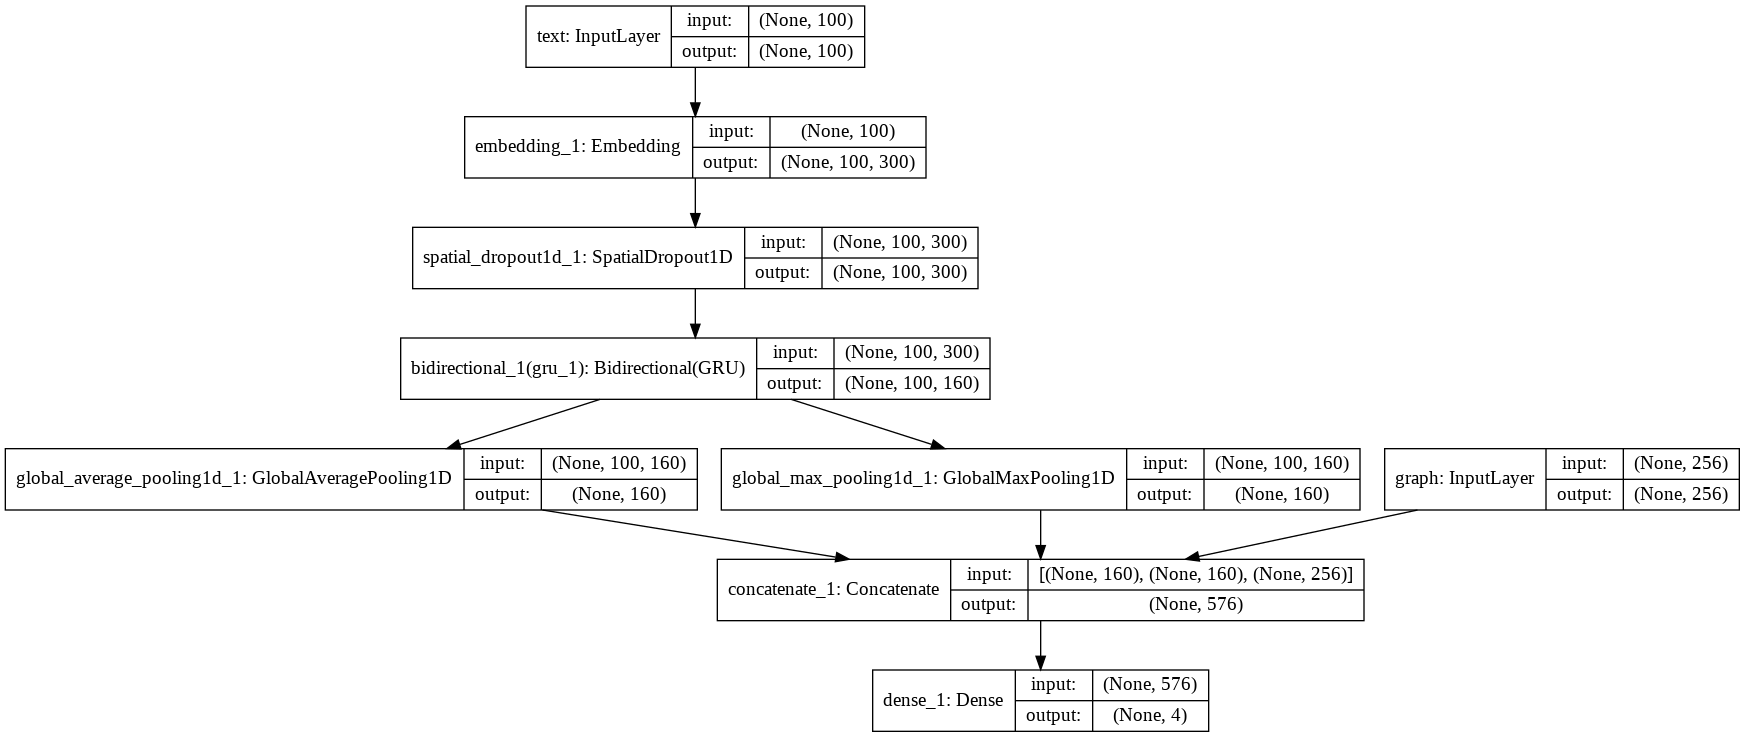

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model = get_model()


batch_size = 32
epochs = 5



# X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit({"text": X_tra, "graph": X_train_graph}, 
                 y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=({"text": X_val, "graph": X_val_graph}, y_val),
                #  callbacks=[RocAuc], 
                 verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1514 samples, validate on 412 samples
Epoch 1/5
 - 23s - loss: 0.5834 - accuracy: 0.7368 - val_loss: 0.5689 - val_accuracy: 0.7488
Epoch 2/5
 - 20s - loss: 0.5320 - accuracy: 0.7533 - val_loss: 0.4879 - val_accuracy: 0.7755
Epoch 3/5
 - 20s - loss: 0.3455 - accuracy: 0.8593 - val_loss: 0.3822 - val_accuracy: 0.8398
Epoch 4/5
 - 20s - loss: 0.1221 - accuracy: 0.9661 - val_loss: 0.3204 - val_accuracy: 0.8805
Epoch 5/5
 - 20s - loss: 0.0366 - accuracy: 0.9921 - val_loss: 0.3304 - val_accuracy: 0.8823


#Kaggle

## Test a grafo

In [ ]:
test.head()

,ID,Tweet,clean_tweet
0,689719109785907200,death toll from #bachakhanuniattack rises to a...,death toll from rises to at least army offici...
1,531300385248800768,"the head of isis, abu bakr al-baghdadi, is sai...",the head of isis abu bakr al baghdadi is said ...
2,652992524504600576,steve jobs was adopted. his biological father ...,steve jobs was adopted his biological father w...
3,509473920060104704,microsoft to buy mojang - report URL $2 billio...,microsoft to buy mojang report url 2 billion...
4,651321040119963648,el chapo puts $100 million bounty on donald tr...,el chapo puts 100 million bounty on donald tru...


In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/test'
fileGraph = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph_test.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, test['ID'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 6671
Number of edges: 7000
Average degree:   2.0986
StellarGraph: Undirected multigraph
 Nodes: 6671, Edges: 7000

 Node types:
  default: [6671]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [7000]
        Weights: all 1 (default)
        Features: none


In [ ]:
file_test = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/node_test.word2vec'

embedding = graphEmbedding(graph, file_test, test['ID'])

embeddings = np.array([embedding.wv[str(x)] for x in test['ID']])

Number of random walks: 21300


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
asd = model.predict({"text": x_test, "graph": embeddings})
asd = np.argmax(asd, axis=1)

In [ ]:
print(asd)

[0 3 0 2 0 0 0 2 2 3 3 1 0 1 2 0 1 2 1 3 0 3 2 0 1 2 0 3 2 0 0 1 0 3 0 1 2
 2 2 2 2 3 0 3 2 0 2 0 2 2 0 2 1 0 1 2 2 0 1 2 3 0 0 0 1 2 1 2 1 2 0 1 2 2
 2 0 0 2 2 2 2 2 2 0 2 1 1 0 1 0 2 3 1 2 3 1 1 0 0 1 0 3 3 3 1 3 0 2 2 1 0
 1 1 0 2 2 0 0 0 1 1 0 1 3 0 2 3 3 0 3 0 2 2 1 2 2 0 1 1 1 2 1 2 1 2 3 2 3
 0 0 1 2 0 0 2 2 0 2 3 3 2 1 0 0 0 2 3 0 0 3 2 2 2 2 1 0 1 0 3 1 0 3 2 1 2
 2 0 0 1 0 1 2 1 2 1 0 0 3 3 1 0 1 0 3 2 2 2 0 0 1 2 1 0]


In [ ]:
pred = le.inverse_transform(asd)

In [ ]:
sample = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/sample_submission.csv')

sample['label'] = pred
sample['id'] = test['ID']
sample.to_csv('sample_node2vec_final.csv', header=True, index=False)